In [1]:
import sys
sys.path.insert(0, "/home/krzysiek/Development/claim-modelling/claim_modelling_kedro/src/")

import logging

logger = logging.getLogger(__name__)
logger.setLevel("INFO")

In [2]:
import os
import mlflow
import logging
import time
import tempfile
from abc import ABC, abstractmethod
from datetime import timedelta
from typing import Any, Dict, Union, List, Tuple

import pandas as pd
import numpy as np


logger = logging.getLogger(__name__)

In [3]:
# !pip install git+https://github.com/krzpiesiewicz/timeseries

In [4]:
from timeseries import Interval, plot_ts
from timeseries.plotting import plot_hist, plot_stats

In [8]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("test")
run = mlflow.start_run(run_name="dev_run")

In [9]:
from claim_modelling_kedro.pipelines.utils.utils import (
    load_metrics_table_from_mlflow,
    load_predictions_and_target_from_mlflow,
    load_metrics_cv_stats_from_mlflow,
    get_partition,
    get_mlflow_run_id_for_partition,
)

In [51]:
mlflow_run_id = "9e92594a898c403481fc72fbcbeeeeb0"
mlflow_run_id = "9495f8c7aaca483d894f0d3f39b58af8"

In [37]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/test")

[<FileInfo: file_size=None, is_dir=True, path='predictions/test/prediction'>,
 <FileInfo: file_size=None, is_dir=True, path='predictions/test/target'>]

In [38]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/sample")

[<FileInfo: file_size=None, is_dir=True, path='predictions/sample/prediction'>,
 <FileInfo: file_size=None, is_dir=True, path='predictions/sample/target'>]

In [52]:
sample_predictions_df, sample_target_df = load_predictions_and_target_from_mlflow(dataset="sample", mlflow_run_id=mlflow_run_id)

In [14]:
calib_predictions_df, calib_target_df = load_predictions_and_target_from_mlflow(dataset="calib", mlflow_run_id=mlflow_run_id)

In [15]:
test_predictions_df, test_target_df = load_predictions_and_target_from_mlflow(dataset="test", mlflow_run_id=mlflow_run_id)

In [40]:
sample_predictions_df["0"].head()

,ClaimSeverity_PRED
IDpol,
2107169,1081.627268
2158993,1030.733399
2075943,1292.806738
2186693,840.436707
3110369,912.763224


In [41]:
sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
1123011         1.490000
177371          1.490000
4166204         1.490000
3057395         1.490000
3047899         1.490000
               ...      
101035      48617.116058
3145824     56629.165508
1193287    112003.186539
2104226    112003.186539
1184070    112003.186539
Name: ClaimSeverity_PRED, Length: 8000, dtype: float64

In [53]:
a = sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()
a[a <= 0]

IDpol
1123011   -368697.184872
3057395   -368697.184872
177371    -117198.423022
4166204    -23012.709369
3047899    -23012.709369
3112717    -23012.709369
Name: ClaimSeverity_PRED, dtype: float64

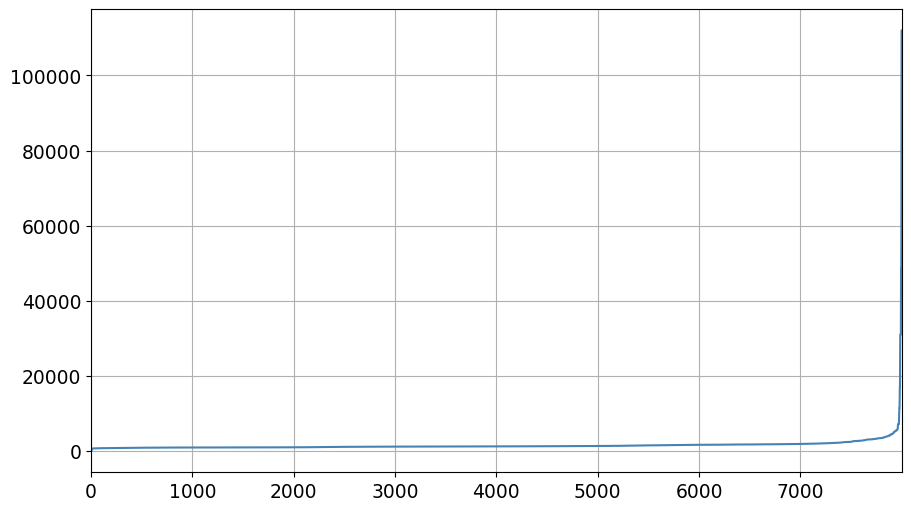

In [46]:
plot_ts(sample_predictions_df["0"].ClaimSeverity_PRED.sort_values().values)

In [54]:
sample_predictions_df["0"].ClaimSeverity_PRED.sum()

11889694.029622028

In [48]:
sample_target_df["0"].ClaimSeverity_TRG.sum()

10576220.395

In [55]:
(sample_predictions_df["0"].ClaimSeverity_PRED.sum() - sample_target_df["0"].ClaimSeverity_TRG.sum()) / sample_target_df["0"].ClaimSeverity_TRG.sum()

0.12419121250943146

In [33]:
calib_predictions_df["0"].head()

,pure_ClaimSeverity_PRED,calibrated_ClaimSeverity_PRED,ClaimSeverity_PRED
IDpol,,,
1120377,1358.561438,3347.807066,3347.807066
3075820,2460.513002,3347.807066,3347.807066
4169019,2704.853022,3347.807066,3347.807066
1096763,1030.856045,2498.224465,2498.224465
2206511,1316.354055,2498.224465,2498.224465


In [31]:
calib_predictions_df["0"].ClaimSeverity_PRED.sum()

23752747.192142863

In [32]:
calib_target_df["0"].ClaimSeverity_TRG.sum()

20765241.754166663

In [35]:
calib_predictions_df["0"].pure_ClaimSeverity_PRED.sort_values()

IDpol
3115657        1.490000
40884          1.490000
2268060        1.490000
175357         1.490000
155666         1.490000
               ...     
41960      31046.781379
6092952    31046.781379
5105891    31046.781379
3123274    48617.116058
2234497    48617.116058
Name: pure_ClaimSeverity_PRED, Length: 8312, dtype: float64

In [10]:
predictions_df

{'0':          pure_ClaimFreq_PRED  calibrated_ClaimFreq_PRED  ClaimFreq_PRED
 IDpol                                                                  
 4169479             0.084812                   0.118505        0.118505
 1029561             0.063508                   0.117399        0.117399
 6101794             0.178691                   0.123507        0.123507
 4120268             0.189139                   0.124076        0.124076
 76230               0.495778                   0.142012        0.142012
 ...                      ...                        ...             ...
 2069846             0.143597                   0.121613        0.121613
 2069826             0.137237                   0.121273        0.121273
 2069827             0.234025                   0.126553        0.126553
 2069892             0.166104                   0.122824        0.122824
 2069907             0.121476                   0.120434        0.120434
 
 [67801 rows x 3 columns],
 '1':          pu

In [26]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="results/test")

[<FileInfo: file_size=2611, is_dir=False, path='results/test/pure_test_metrics_by_part.csv'>,
 <FileInfo: file_size=684, is_dir=False, path='results/test/pure_test_metrics_cv_stats.csv'>,
 <FileInfo: file_size=2590, is_dir=False, path='results/test/test_metrics_by_part.csv'>,
 <FileInfo: file_size=632, is_dir=False, path='results/test/test_metrics_cv_stats.csv'>]

In [37]:
def load_pd_dataframe_csv_from_mlflow(artifact_path: str, filename: str = None,mlflow_run_id: str = None, index_col=None,
                                      columns_index_name=None) -> pd.DataFrame:
    if mlflow_run_id is None:
        mlflow_run_id = mlflow.active_run().info.run_id
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact_path = f"{artifact_path}/{filename}" if filename is not None else artifact_path
        artifact_uri = f"runs:/{mlflow_run_id}/{artifact_path}"
        local_path = mlflow.tracking.artifact_utils._download_artifact_from_uri(artifact_uri, temp_dir)
        df = pd.read_csv(local_path, index_col=index_col)
        df.columns.name = columns_index_name
        return df

In [38]:
def _file_name(dataset: str, prefix: str = None, suffix: str = None, ext: str = None) -> str:
    filename = f"{prefix}_{dataset}" if prefix is not None else dataset
    filename = f"{filename}_{suffix}" if suffix is not None else filename
    return f"{filename}.{ext}" if ext is not None else filename


def get_metrics_table_filname_and_artifact_path(dataset: str, prefix: str = None) -> Tuple[str, str]:
    filename = _file_name(dataset, prefix, "metrics_by_part", "csv")
    artifact_path = f"results/{dataset}"
    return filename, artifact_path


def save_metrics_table_in_mlflow(metrics_df: pd.DataFrame, dataset: str, prefix: str = None):
    csv_filename, artifact_path = get_metrics_table_filname_and_artifact_path(dataset, prefix)
    save_pd_dataframe_as_csv_in_mlflow(metrics_df, artifact_path=artifact_path, csv_filename=csv_filename)


def load_metrics_table_from_mlflow(dataset: str, prefix: str = None, mlflow_run_id: str = None) -> pd.DataFrame:
    filename, artifact_path = get_metrics_table_filname_and_artifact_path(dataset, prefix)
    metrics_df = load_pd_dataframe_csv_from_mlflow(artifact_path, filename, mlflow_run_id, index_col="metric",
                                                   columns_index_name="part")
    return metrics_df

In [41]:
def get_metrics_cv_stats_filname_and_artifact_path(dataset: str, prefix: str = None) -> Tuple[str, str]:
    filename = _file_name(dataset, prefix, "metrics_cv_stats", "csv")
    artifact_path = f"results/{dataset}"
    return filename, artifact_path


def load_metrics_cv_stats_from_mlflow(dataset: str, prefix: str = None, mlflow_run_id: str = None) -> pd.DataFrame:
    filename, artifact_path = get_metrics_cv_stats_filname_and_artifact_path(dataset, prefix)
    metrics_cv_stats_df = load_pd_dataframe_csv_from_mlflow(artifact_path, filename, mlflow_run_id, index_col="metric")
    return metrics_cv_stats_df

In [42]:
metrics_cv_stats = load_metrics_cv_stats_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [43]:
metrics_by_part = load_metrics_table_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [44]:
metrics_by_part

part,0,1,2,3,4,5,6,7,8,9
metric,,,,,,,,,,
test_MPD,0.885846,1.052887,1.027052,0.944465,1.111153,0.825786,0.929565,1.133675,0.961578,1.134429
test_wMPD,0.505019,0.502245,0.489405,0.494871,0.484315,0.488367,0.500906,0.494655,0.497689,0.491305
test_RMSE,1.513411,2.012962,2.210971,1.782154,2.090518,1.157011,2.081918,2.446309,1.874213,2.471737
test_wRMSE,0.475220,0.497380,0.490774,0.474673,0.507172,0.460856,0.478562,0.513426,0.475881,0.522860
test_R2,-0.000013,-0.000033,0.000057,-0.000039,-0.000118,0.000160,-0.000037,0.000024,0.000135,-0.000001
test_wR2,-0.009950,-0.008303,-0.005438,-0.012563,-0.003927,-0.005484,-0.012740,-0.006914,-0.012645,-0.004112
test_MBD,-0.013600,0.003708,0.007861,-0.015178,0.021936,-0.005455,-0.018451,0.014418,-0.014462,0.018672
test_wMBD,-0.048384,-0.044381,-0.038422,-0.054090,-0.032194,-0.035958,-0.053802,-0.040086,-0.053971,-0.035364
test_SC,0.026622,0.022289,0.028210,0.023575,0.019243,0.023648,0.024641,0.023222,0.027876,0.026632
